# Steps:
- 1. Load Dataset
- 2. Make Dataset Iterable
- 3. Create Model Class
- 4. Instantiate Model Class
- 5. Instantiate Loss Class
- 6. Instantiate Opitmizer Class
- 7. Train Model

##  Step 1:Loading MNIST Train Dataset
**Image from 1 to 9 **


In [5]:
!pip install torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [6]:
train_dataset = dsets.MNIST(root='./data',
                            train= True,transform = transforms.ToTensor(),
                            download= True)

test_dataset = dsets.MNIST(root='./data',
                          train= False,
                          transform = transforms.ToTensor())

In [7]:
print(train_dataset.train_data.size())


torch.Size([60000, 28, 28])


In [8]:
print(train_dataset.train_labels.size())

torch.Size([60000])


In [9]:
print(test_dataset.test_data.size())

torch.Size([10000, 28, 28])


In [10]:
print(test_dataset.test_labels.size())

torch.Size([10000])


## Step 2 : Make Dataset Iterable

In [11]:
'''Batch size is a term used in machine learning and refers to the number
of training examples utilized in one iteration. The batch size can be
one of three options: batch mode: where the batch size is equal to the
 total dataset thus making the iteration and epoch values equivalent.'''
batch_size = 100

n_iters = 3000
num_epochs = n_iters/(len(train_dataset) /batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset= train_dataset,
                                          batch_size=batch_size,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle= False)
 

# Step 3:Create Model Class

In [12]:
class LSTMModel(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim ):
        super(LSTMModel,self).__init__()
        # Hidden dimesions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building LSTM
        # batch_first = True causes input/output tensors to be of shape
        #(batch_dim,seq_dim,feature_dim)
        self.lstm = nn.LSTM(input_dim,hidden_dim,layer_dim,batch_first=True)
        
        #Readout Layer
        self.fc = nn.Linear(hidden_dim,output_dim)
        
    def forward(self,x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim,x.size(0),self.hidden_dim))
        
        #Initialize cell state
        c0 = Variable(torch.zeros(self.layer_dim,x.size(0),self.hidden_dim))
        
        # 28 time step
        out, (hn,cn) = self.lstm(x,(h0,c0))
        
        #Index hidden stat of last time step
        # out.size() --> 100,28,100
        #out[:,-1,:] -->100,100 --> just want last time step hidden states!
        out = self.fc(out[:,-1,:])
        #out.size() -->100,10
        return out
        

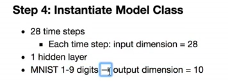

In [13]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10


In [14]:
model = LSTMModel(input_dim,hidden_dim,layer_dim,output_dim)

# Step 5 :Instantiate Loss Class

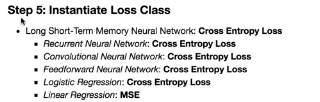

In [15]:
criterion = nn.CrossEntropyLoss()

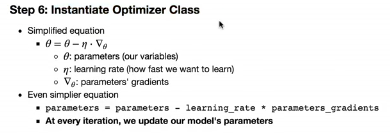

In [16]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

# Parameters In-Depth

In [17]:
len(list(model.parameters()))

6

In [19]:
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 28])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])


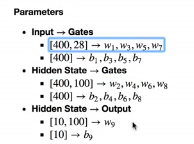

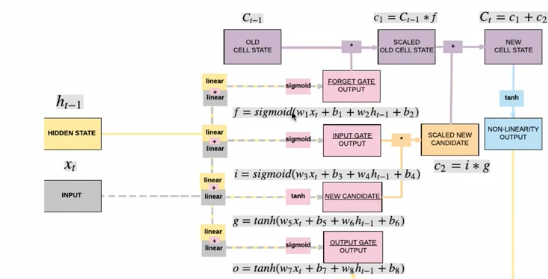

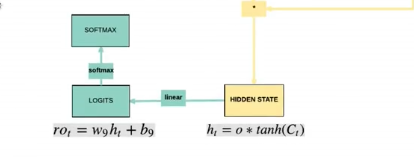

![image.png](attachment:image.png)

# Step 7:  Train Model
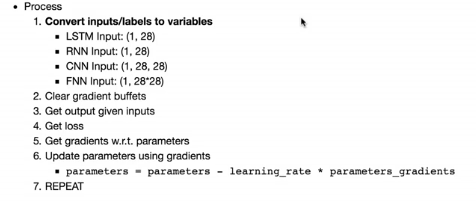



In [21]:
# Number of steps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        #Load images as Variable
        images =Variable(images.view(-1,seq_dim,input_dim))
        labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        #Forward pass to get ouput/logits
        #outputs.size() --> 100,10
        outputs = model(images)
        
        #Calculate Loss:softmax -->cross entropy loss
        loss = criterion(outputs,labels)
        
        #Getting gradients w.r.t parameters
        loss.backward()
        
        #Updating parameters
        optimizer.step()
        
        iter += 1
        if iter % 500 == 0:
            #Calculate Accuracy
            correct = 0
            total = 0
            #Iterate through test dataset
            for images,labels in test_loader:
                # Load images to a Torch Variable
                images = Variable(images.view(-1,seq_dim,input_dim))
                
                #Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data,1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                
                correct += (predicted ==labels).sum()
                
            accuracy = 100*correct/total
            
            
            #Print Loss
            print('Iteration:{}.Loss:{}.Accuracy:{}'.format(iter,loss.data[0],accuracy))
            
            

/home/pratik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration:500.Loss:2.251749038696289.Accuracy:23
Iteration:1000.Loss:1.0506949424743652.Accuracy:65
Iteration:1500.Loss:0.38975799083709717.Accuracy:87
Iteration:2000.Loss:0.29530104994773865.Accuracy:90
Iteration:2500.Loss:0.1867622435092926.Accuracy:94
Iteration:3000.Loss:0.13215109705924988.Accuracy:96


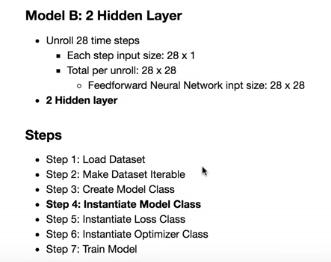